# Forecasting Energy Demand

This tutorial is based on the scenario used in [Skforecast](https://cienciadedatos.net/documentos/py29-forecasting-electricity-power-demand-python.html).

Here, we use the [Australian Electricity Demand dataset](https://zenodo.org/records/4659727). This dataset compiles the energy demand for five Australian cities at a half-hourly frequency.

In this experiment, we show that using TimeGPT delivers significant improvements over using a state-of-the-art deep learning model like N-HiTS in a just a few lines of code:

- MAE of TimeGPT is **7.8% better** than N-HiTS
- sMAPE of TimeGPT is **11.5% better** than N-HiTS
- TimeGPT generated predictions in **7.7 seconds**, which is **88% faster** than training and predicting with N-HiTS.

The following tutorial explore all the steps in detail to reproduce these results so that you can apply TimeGPT in your own project.

In [ ]:
#| hide
%set_env PYTORCH_ENABLE_MPS_FALLBACK=1

env: PYTORCH_ENABLE_MPS_FALLBACK=1


In [ ]:
#| hide
import sys

In [ ]:
#| hide
IN_COLAB = 'google.colab' in sys.modules

In [ ]:
#| hide
if IN_COLAB:
    %pip install nixtla utilsforecast neuralforecast

In [ ]:
#| hide
if not IN_COLAB:
    from nixtla.utils import colab_badge
    from dotenv import load_dotenv        

In [ ]:
#| echo: false
if not IN_COLAB:
    load_dotenv()
    colab_badge('docs/tutorials/3_electricity_demand')

[![](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/Nixtla/nixtla/blob/main/nbs/docs/tutorials/3_electricity_demand.ipynb)

## Initial setup

First, we load the required packages for this experiment.

In [ ]:
import time
import requests
import pandas as pd

from nixtla import NixtlaClient

from utilsforecast.losses import mae, smape
from utilsforecast.evaluation import evaluate

Of course, we need an instance of `NixtlaClient` to use TimeGPT.

In [ ]:
nixtla_client = NixtlaClient(
    # defaults to os.environ.get("NIXTLA_API_KEY")
    api_key = 'my_api_key_provided_by_nixtla'
)

In [ ]:
#| hide
if not IN_COLAB:
    nixtla_client = NixtlaClient()

## Read the data

Here, we define a helper function to help us read the `.tsf` file that contains our data. The dataset is available on [GitHub](https://github.com/Nixtla/transfer-learning-time-series/blob/main/datasets/australian_electricity_demand_dataset.tsf).

In [ ]:
def read_tsf_from_url(url):
    data = []
    start_date = pd.to_datetime('2002-01-01 00:00:00')
    
    # Fetch the content from the URL
    response = requests.get(url)
    response.raise_for_status()

    # Process each line of the file
    for line in response.text.splitlines():
        if line.startswith('T'):
            parts = line.strip().split(':')
            unique_id = parts[0] + '-' + parts[1]
            values = list(map(float, parts[3].split(',')[:-1]))
            
            # Generate datetime index at half-hour intervals
            periods = len(values)
            date_range = pd.date_range(start=start_date, periods=periods, freq='30min')
            
            # Append to data list
            for dt, value in zip(date_range, values):
                data.append([unique_id, dt, value])

    return pd.DataFrame(data, columns=['unique_id', 'ds', 'y'])

url = 'https://raw.githubusercontent.com/Nixtla/transfer-learning-time-series/main/datasets/australian_electricity_demand_dataset.tsf'
df = read_tsf_from_url(url)

In [ ]:
df.groupby('unique_id').head(2)

,unique_id,ds,y
0,T1-NSW,2002-01-01 00:00:00,5714.045004
1,T1-NSW,2002-01-01 00:30:00,5360.189078
230735,T2-VIC,2002-01-01 00:00:00,3535.867064
230736,T2-VIC,2002-01-01 00:30:00,3383.499028
461470,T3-QUN,2002-01-01 00:00:00,3382.041342
461471,T3-QUN,2002-01-01 00:30:00,3288.315794
693741,T4-SA,2002-01-01 00:00:00,1191.078014
693742,T4-SA,2002-01-01 00:30:00,1219.589472
924524,T5-TAS,2002-01-01 00:00:00,315.915504
924525,T5-TAS,2002-01-01 00:30:00,306.245864


Let's plot our series to see what it looks like.

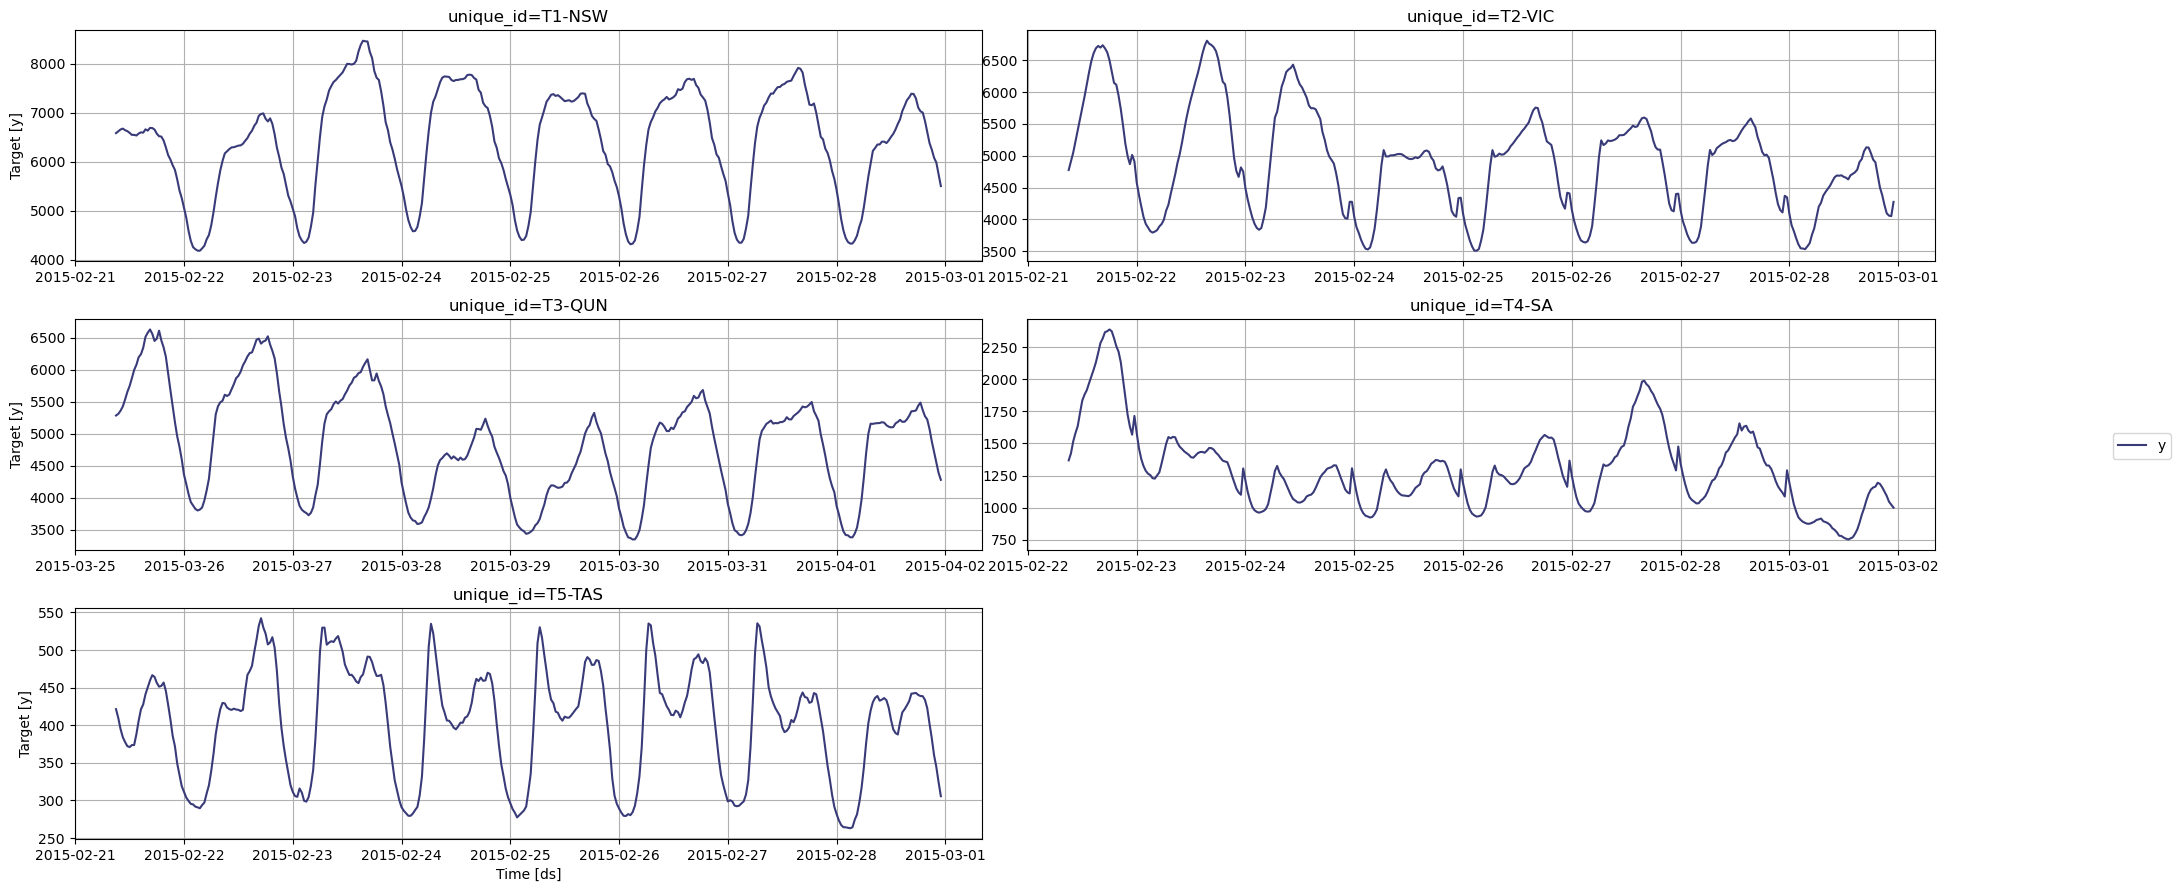

In [ ]:
nixtla_client.plot(
    df, 
    max_insample_length=365, 
)

We can see clear sesaonal pattern in all of our series. It will be interesting to see how TimeGPT handles this type of data.

## Forecasting with TimeGPT
### Splitting the data

The first step is to split our data. Here, we define an input DataFrame to feed to the model. We also reserve the last 96 time steps for the test set, so that we can evaluate the performance of TimeGPT against actual values.

For this situation, we use a forecast horizon of 96, which represents two days, and we use an input sequence of 21 days, which is 1008 time steps.

In [ ]:
test_df = df.groupby('unique_id').tail(96)                                                             # 96 = 2 days (96 * 0.5h *  1 day/24h )

input_df = df.groupby('unique_id').apply(lambda group: group.iloc[-1104:-96]).reset_index(drop=True)   # 1008 = 21 days (1008 *0.5h * 1 day/24h)

### Forecasting

Then, we simply call the `forecast` method. Here, we use fine-tuning and specify the mean absolute error (MAE) as the fine-tuning loss. Also, we use the `timegpt-1-long-horizon` since we are forecasting the next two days, and the seasoanl period is one day.

In [ ]:
start = time.time()

fcst_df = nixtla_client.forecast(
    df=input_df,
    h=96,                            
    level=[90],                        # Generate a 90% confidence interval
    finetune_steps=10,                 # Specify the number of steps for fine-tuning
    finetune_loss='mae',               # Use the MAE as the loss function for fine-tuning
    model='timegpt-1-long-horizon',    # Use the model for long-horizon forecasting
    time_col='ds',
    target_col='y',
    id_col='unique_id'
)

end = time.time()

timegpt_duration = end - start

print(f"Time (TimeGPT): {timegpt_duration}")

INFO:nixtla.nixtla_client:Validating inputs...
INFO:nixtla.nixtla_client:Preprocessing dataframes...
INFO:nixtla.nixtla_client:Inferred freq: 30T
INFO:nixtla.nixtla_client:Calling Forecast Endpoint...


Time (TimeGPT): 4.3835554122924805


TimeGPT was done in 7.7 seconds! We can now plot the predictions against the actual values of the test set.

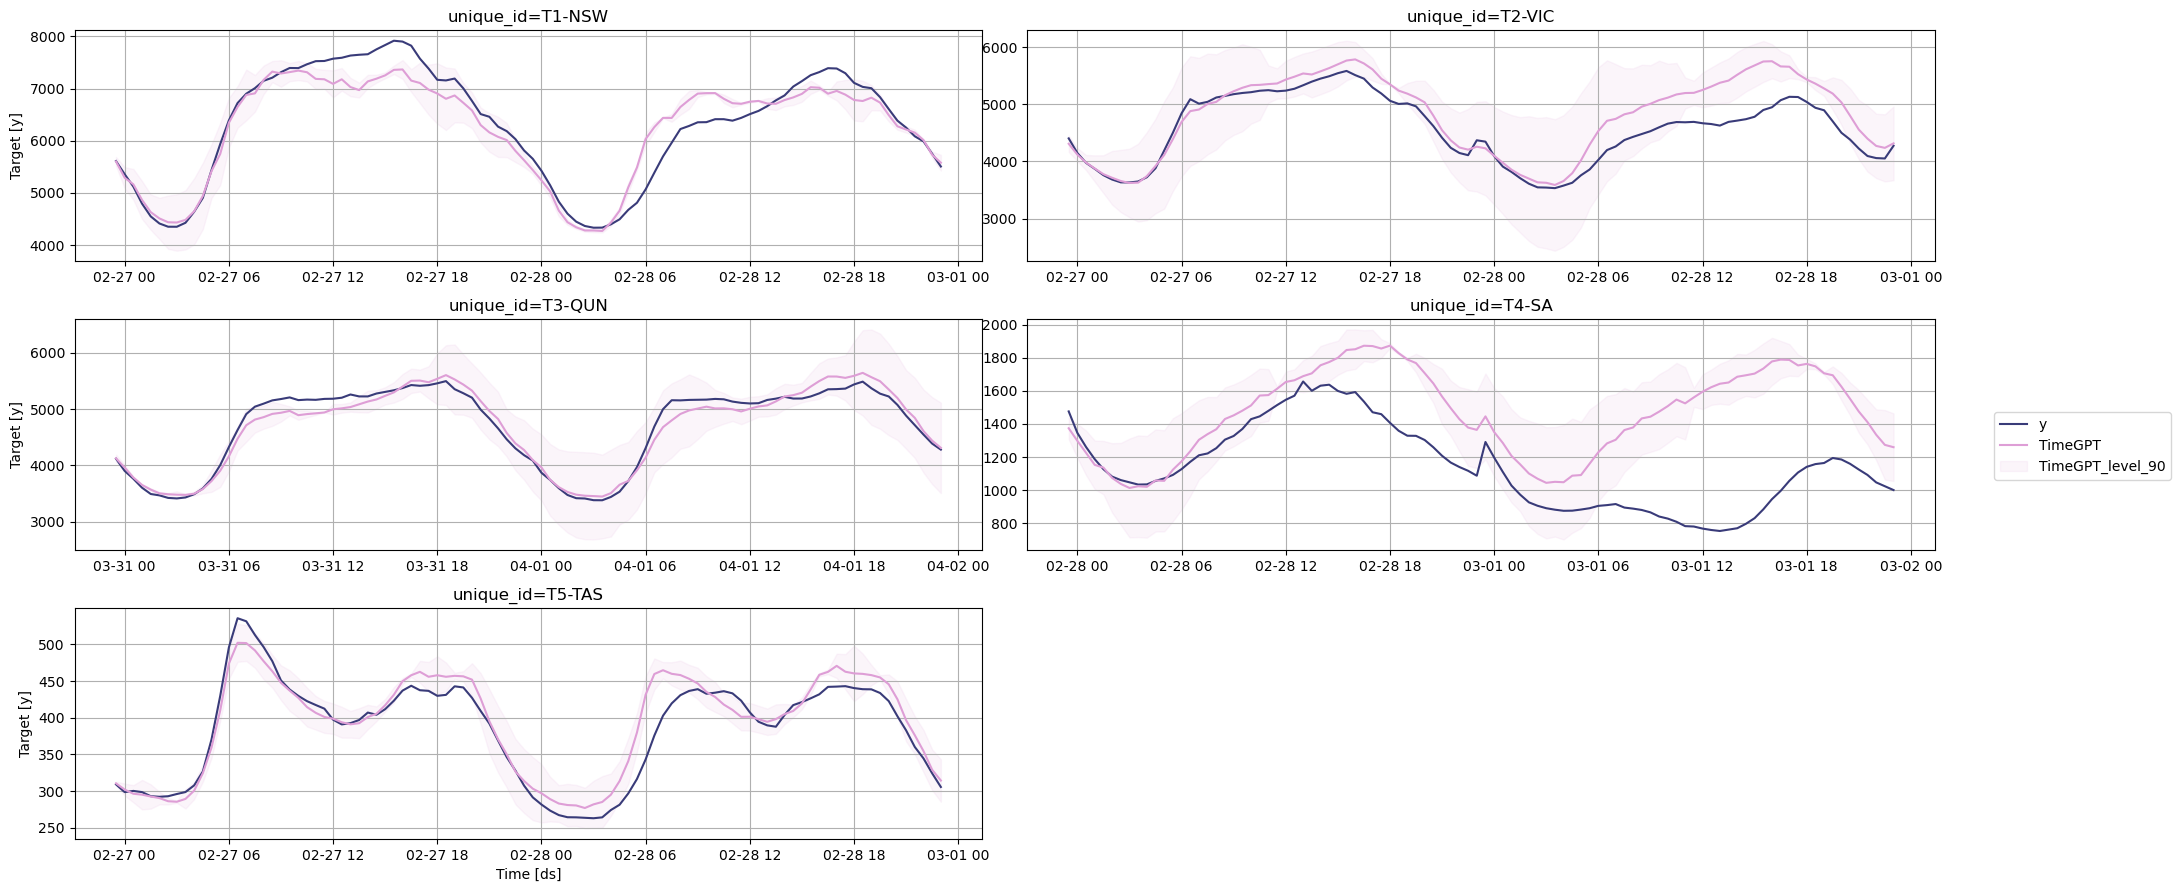

In [ ]:
nixtla_client.plot(test_df, fcst_df, models=['TimeGPT'], level=[90], time_col='ds', target_col='y')


### Evaluation

Now that we have predictions, let's evaluate the model's performance.

In [ ]:
fcst_df['ds'] = pd.to_datetime(fcst_df['ds'])

test_df = pd.merge(test_df, fcst_df, 'left', ['unique_id', 'ds'])

In [ ]:
evaluation = evaluate(
    test_df,
    metrics=[mae, smape],
    models=["TimeGPT"],
    target_col="y",
    id_col='unique_id'
)

average_metrics = evaluation.groupby('metric')['TimeGPT'].mean()
average_metrics

metric
mae      198.822327
smape      0.041998
Name: TimeGPT, dtype: float64

We can see that TimeGPT achieves a MAE of 198.82 and a sMAPE of 4.2%.

Great! Now, let's see if a data-specific model can do better.

## Forecasting with N-HiTS

Here, we use the N-HiTS model, as it is very fast to train and performs well on long-horizon forecasting tasks. To reproduce these results, make sure to install the library `neuralforecast`.

In [ ]:
from neuralforecast.core import NeuralForecast
from neuralforecast.models import NHITS

### Define the training set

The training set is different from the input DataFrame for TimeGPT, as we need more data to train a data-specific model. 

Note that the dataset is very large, so we use the last 400 days of the training set to fit our model.

In [ ]:
train_df = df.groupby('unique_id').apply(lambda group: group.iloc[-9696:-96]).reset_index(drop=True)

### Forecasting with N-HiTS

We can now fit the model on training set and make predictions.

In [ ]:
horizon = 96

models = [NHITS(h=horizon, input_size = 5*horizon, scaler_type='robust', batch_size=16, valid_batch_size=8)]

nf = NeuralForecast(models=models, freq='30min')

start = time.time()

nf.fit(df=train_df)
nhits_preds = nf.predict()

end = time.time()

nhits_duration = end - start

print(f"Time (N-HiTS): {nhits_duration}")

c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\utilities\parsing.py:199: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
INFO:lightning_fabric.utilities.seed:Seed set to 1
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
INFO:pytorch_lightning.callbacks.model_summary:
  | Name         | Type          | Params
-----------------------------------------------
0 | loss         | MAE           | 0     
1 | padder_train | ConstantPad1d | 0     
2 | scaler       | TemporalNorm  | 0     
3 | blocks       | ModuleList    | 3.7 M 
-----------------------------------------------
3

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=19` in the `DataLoader` to improve performance.
c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\loops\fit_loop.py:298: The number of training batches (1) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.


Training: |          | 0/? [00:00<?, ?it/s]

c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\utilities\data.py:77: Trying to infer the `batch_size` from an ambiguous collection. The batch size we found is 5. To avoid any miscalculations, use `self.log(..., batch_size=batch_size)`.


Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

INFO:pytorch_lightning.utilities.rank_zero:`Trainer.fit` stopped: `max_steps=1000` reached.
c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\neuralforecast\tsdataset.py:92: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  self.temporal = torch.tensor(temporal, dtype=torch.float)
INFO:pytorch_lightning.utilities.rank_zero:GPU available: False, used: False
INFO:pytorch_lightning.utilities.rank_zero:TPU available: False, using: 0 TPU cores
INFO:pytorch_lightning.utilities.rank_zero:IPU available: False, using: 0 IPUs
INFO:pytorch_lightning.utilities.rank_zero:HPU available: False, using: 0 HPUs
c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\pytorch_lightning\trainer\connectors\data_connector.py:441: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers`

Predicting: |          | 0/? [00:00<?, ?it/s]

Time (N-HiTS): 109.76545667648315


c:\Users\ospra\miniconda3\envs\nixtla\lib\site-packages\neuralforecast\core.py:184: FutureWarning: In a future version the predictions will have the id as a column. You can set the `NIXTLA_ID_AS_COL` environment variable to adopt the new behavior and to suppress this warning.
  warnings.warn(


Great! Note that N-HiTS took 67 seconds to carry out the training and forecasting procedures. Now, let's evaluate the performance of this model.

### Evaluation

In [ ]:
preds_df = pd.merge(test_df, nhits_preds, 'left', ['unique_id', 'ds'])

evaluation = evaluate(
    preds_df,
    metrics=[mae, smape],
    models=["NHITS"],
    target_col="y",
    id_col='unique_id'
)


average_metrics = evaluation.groupby('metric')['NHITS'].mean()
print(average_metrics)

metric
mae      224.794047
smape      0.048017
Name: NHITS, dtype: float64


## Conclusion

TimeGPT achieves a MAE of 198.82 while N-HiTS achieves a MAE of 215.55, meaning there is a **7.8% improvement** in using TimeGPT versus our data-specific N-HiTS model. TimeGPT also improved the sMAPE by 11.5%.

Plus, TimeGPT took 7.7 seconds to generate forecasts, while N-HiTS took 67 seconds to fit and predict. TimeGPT is thus **88% faster** than using N-HiTS in this scenario. 